In [2]:
import scipy.io as sio
from scipy.signal import welch
from scipy import stats
import numpy as np
from glob import glob
from sklearn.metrics import mutual_info_score, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
import pylab
import math
from functools import partial
from itertools import combinations
from os import path
import pickle
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pylab.rcParams['figure.figsize'] = (18, 8)

def loadSubject(filename):
    return sio.loadmat(filename)['data']

def allSubjects():
    return sorted(glob('dataset/*'))

sujetoP01 = loadSubject('dataset/P01.mat')
cant_electrodos = len(sujetoP01[0])
cant_muestras_por_electrodo = len(sujetoP01[0, 0])
long_epoch = 0.8  # segundos
nfft = 2047
longitud_de_poderes = math.ceil(nfft / 2)
bandas = [0, 4, 8, 13, 30, 45] 
nombre_bandas = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

class Bandas:
    Delta = 0, 4
    Theta = 4, 8
    Alpha = 8, 13
    Beta = 13, 30
    Gamma = 30, 45

# Redefino welch para que siempre tenga el mismo fs y nfft
welch_eeg = partial(welch, fs=90, nfft=nfft, nperseg=cant_muestras_por_electrodo)
frecuencias, _ = welch_eeg(sujetoP01[0, 0], fs=90)

In [3]:
def getBanda(frecuencia):
    """ [0, 4, 8, 13, 30, 45]  # Delta, Theta, Alpha, Beta, Gamma """
    res = 0
    for indice, lim_izq in enumerate(bandas):
        if frecuencia >= lim_izq:
            res = indice
        else:
            break
    return res

assert getBanda(1) == 0
assert getBanda(6) == 1
assert getBanda(10) == 2
assert getBanda(15) == 3
assert getBanda(33) == 4
assert getBanda(50) == 5

def get_name(filename):
    return path.splitext(path.split(filename)[1])[0]

In [14]:
def get_cantidad_de_bines(data, minimo, maximo):
    return np.ceil(
        (maximo - minimo)
        /
        (3.5 * np.std(data) * (len(data) ** (-1/3)))
    )

def get_bins_entropia():
    minimo, maximo, cantidad_de_bines = 0, 0, 0

    for index, filename in enumerate(allSubjects()):
        subject_data = loadSubject(filename)  # epoch, electrodo, muestra
        min_sujeto, max_sujeto, max_cantidad_de_bines_sujeto = 0, 0, 0

        for epoch in subject_data:
            for electrodo in epoch:
                min_electrodo, max_electrodo = np.min(electrodo), np.max(electrodo)
                min_sujeto = min(min_electrodo, min_sujeto)
                max_sujeto = max(max_electrodo, max_sujeto)
                cantidad_de_bines_electrodo = get_cantidad_de_bines(electrodo, min_electrodo, max_electrodo)
                max_cantidad_de_bines_sujeto = max(max_cantidad_de_bines_sujeto, cantidad_de_bines_electrodo)
                
        minimo = min(minimo, min_sujeto)
        maximo = max(maximo, max_sujeto)
        cantidad_de_bines = max(cantidad_de_bines, max_cantidad_de_bines_sujeto)

    return np.linspace(minimo, maximo, cantidad_de_bines)

if not path.exists('bins_entropia.pickle'):
    with open('bins_entropia.pickle', 'wb') as f:
        pickle.dump(get_bins_entropia(), f)
        
with open('bins_entropia.pickle', 'rb') as f:
    bins_entropia = pickle.load(f)
    print(len(bins_entropia), bins_entropia)

21 [ -1.67786768e-03  -1.51389966e-03  -1.34993163e-03  -1.18596361e-03
  -1.02199558e-03  -8.58027555e-04  -6.94059529e-04  -5.30091504e-04
  -3.66123478e-04  -2.02155452e-04  -3.81874268e-05   1.25780599e-04
   2.89748624e-04   4.53716650e-04   6.17684676e-04   7.81652701e-04
   9.45620727e-04   1.10958875e-03   1.27355678e-03   1.43752480e-03
   1.60149283e-03]


In [17]:
def calc_MI(x, y):
    c_xy = np.histogram2d(x, y, bins_entropia)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

Para cada sujeto, calculamos las potencias por banda, la entropía y la información conjunta, en media y desviación estándar. Ya que esto es costoso lo ejecutamos una vez y lo guardamos en un archivo JSON

In [18]:
features_per_subject = {}

def binnear_potencias_por_banda(poderes_espectrales):
    hist = np.zeros(len(bandas) - 1)
    
    for frecuencia, poder in zip(frecuencias, poderes_espectrales):
        hist[getBanda(frecuencia)] += poder
        
    return hist

def get_filename_for_electrodes(electrodos):
    return 'features_per_subject_{}.pickle'.format("_".join((str(e) for e in electrodos)))

def calcularData(electrodos):
    for filename in allSubjects():
        print(filename)
        subject_data = loadSubject(filename)  # epoch, electrodo, muestra
        cant_epochs = len(subject_data)
        potencias_por_banda_por_epoch = np.zeros((cant_epochs, len(bandas) - 1))
        entropias_por_epoch = np.zeros(cant_epochs)

        for index, epoch in enumerate(subject_data):
            potencias_por_banda = np.zeros(len(bandas) - 1)
            if len(electrodos) == 1:
                pares_de_electrodos = [(electrodos[0], electrodos[0])]
            else:
                pares_de_electrodos = list(combinations(electrodos, 2))
            entropia_por_electrodo = 0.0
            entropia_inter_electrodo = np.zeros(len(pares_de_electrodos))

            for num_electrodo in electrodos:
                electrodo = epoch[num_electrodo]
                _, poder_espectral = welch_eeg(electrodo)

                hist, _ = np.histogram(electrodo, bins_entropia)
                entropia_por_electrodo += stats.entropy(hist, base=2)

                potencias_por_banda += binnear_potencias_por_banda(poder_espectral)

            # Calculamos la información mutua entre todos los pares de electrodos elegidos
            for i, (e1, e2) in enumerate(pares_de_electrodos):
                entropia_inter_electrodo[i] += calc_MI(epoch[e1], epoch[e2])

            potencias_por_banda_por_epoch[index] = potencias_por_banda / len(electrodos)
            entropias_por_epoch[index] = entropia_por_electrodo / len(electrodos)

        potencias_medias = np.mean(potencias_por_banda_por_epoch, axis=0)
        desviaciones_medias = np.std(potencias_por_banda_por_epoch, axis=0)
        entropia_inter_electrodo /= cant_epochs
        features_per_subject[get_name(filename)] = {
            'potencias_medias': potencias_medias,
            'potencias_medias_norm': potencias_medias / np.sum(potencias_medias),
            'potencias_std': desviaciones_medias,
            'potencias_std_norm': desviaciones_medias / np.sum(desviaciones_medias),
            'entropia_media': np.mean(entropias_por_epoch),
            'entropia_std': np.std(entropias_por_epoch),
            'informacion_mutua_media': np.mean(entropia_inter_electrodo),
            'informacion_mutua_std': np.std(entropia_inter_electrodo)
        }
    
    with open(get_filename_for_electrodes(electrodos), 'wb') as f:
        pickle.dump(features_per_subject, f)
        
def get_data_for_electrodes(electrodos):
    filename = get_filename_for_electrodes(electrodos)
    if not path.exists(filename):
        calcularData(electrodos)
        
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [19]:
get_data_for_electrodes([0])

{'P01': {'entropia_media': 5.5475958177739324,
  'entropia_std': 0.51420922764358123,
  'informacion_mutua_media': 0.0043348674015325928,
  'informacion_mutua_std': 0.0,
  'potencias_medias': array([  3.06291217e-09,   9.82951011e-11,   8.19232544e-11,
           4.08918272e-11,   4.52659663e-20]),
  'potencias_medias_norm': array([  9.32670926e-01,   2.99313130e-02,   2.49460099e-02,
           1.24517506e-02,   1.37836961e-11]),
  'potencias_std': array([  7.93209543e-09,   1.40781310e-10,   1.32624416e-10,
           8.06258224e-11,   9.62649365e-20]),
  'potencias_std_norm': array([  9.57274183e-01,   1.69900015e-02,   1.60055979e-02,
           9.73021806e-03,   1.16176033e-11])},
 'P02': {'entropia_media': 5.6704246597921166,
  'entropia_std': 0.35086688323163084,
  'informacion_mutua_media': 0.0059387216224041327,
  'informacion_mutua_std': 0.0,
  'potencias_medias': array([  2.64740984e-09,   1.15325834e-10,   7.48165744e-11,
           3.08218225e-11,   3.42901892e-20]),
  'po

In [20]:
def get_target_vector(features_per_subject):
    return [0 if 'P' in subject else 1 for subject in features_per_subject.keys()]

def draw_roc_curve(y_true, y_score, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
        
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# P == 0, S == 1
def draw_roc_curve_for_features(features_per_subject, attr, banda=None):
    y_true = get_target_vector(features_per_subject)
    y_score = [feature[attr] for feature in features_per_subject.values()]
    
    if banda is not None:
        y_score = [v[banda] for v in y_score]
        title = "ROC Curve for {} (banda {})".format(attr, banda)
    else:
        title = "ROC Curve for {}".format(attr)

    draw_roc_curve(y_true, y_score, title)


def draw_roc_curve_for_all_features(features_per_subject):
    for feature_name, values in features_per_subject['P01'].items():
        if isinstance(values, float):
            draw_roc_curve_for_features(features_per_subject, feature_name)
        else:
            for index, _ in enumerate(values):
                draw_roc_curve_for_features(features_per_subject, feature_name, index)

In [21]:
def draw_roc_curve_for_electrodes(electrodos):
    features_per_subject = get_data_for_electrodes(electrodos)
    draw_roc_curve_for_all_features(features_per_subject)

Arbitrariamente tomamos el electrodo 0 y graficamos las curvas ROC para todos los features pedidos

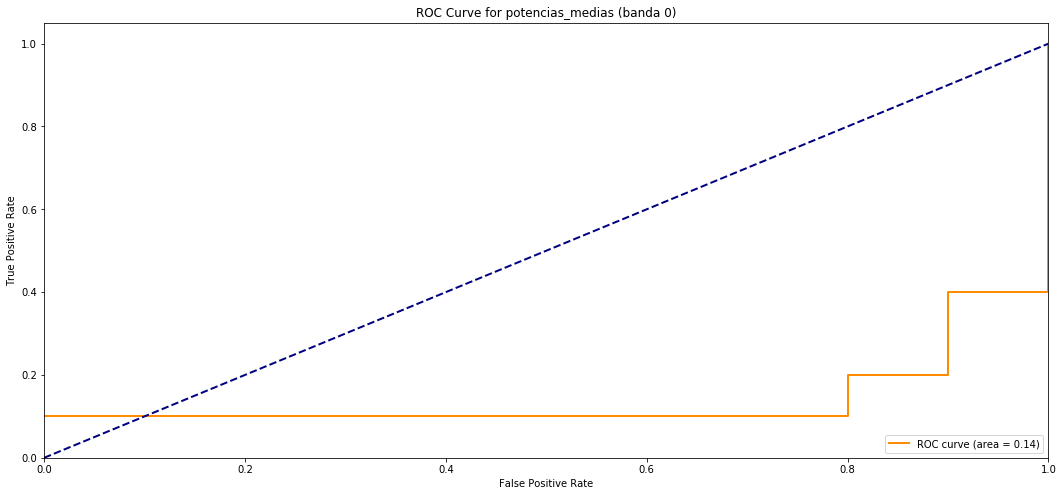

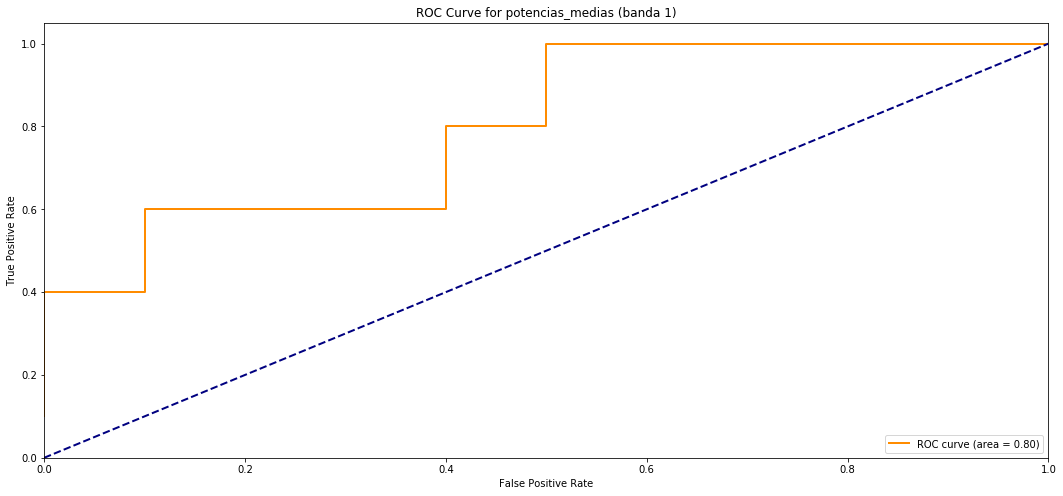

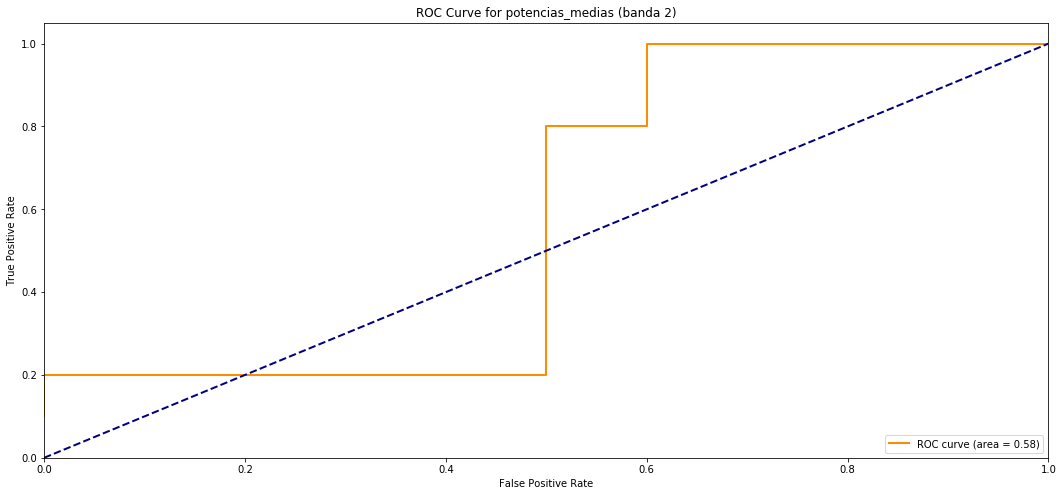

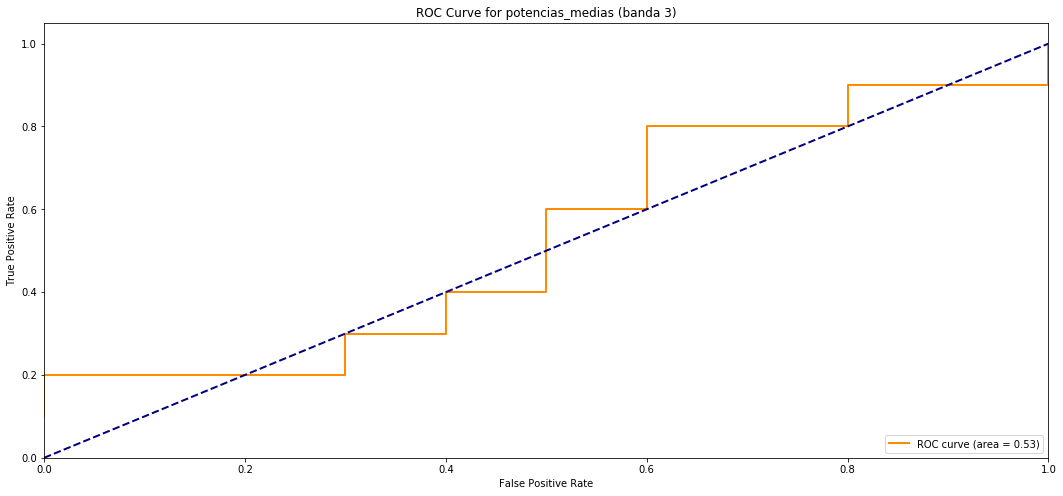

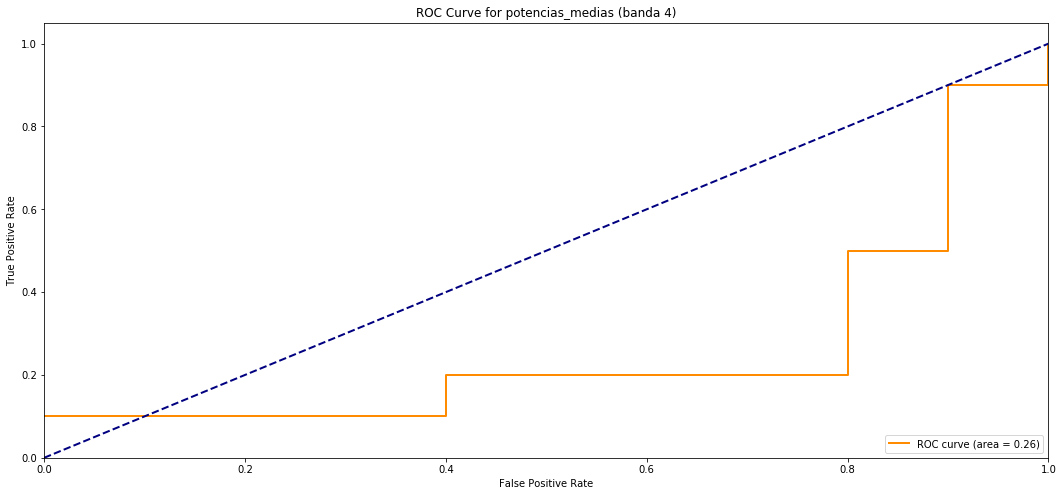

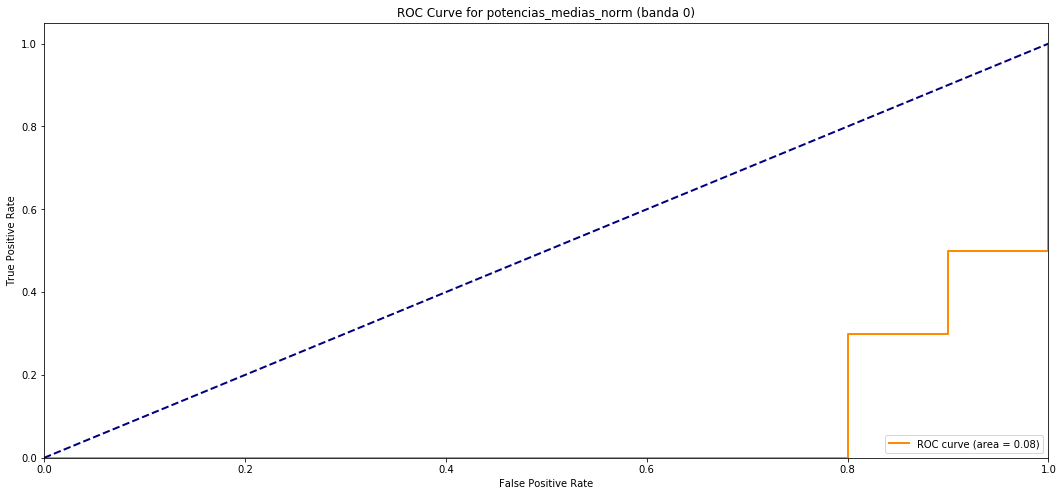

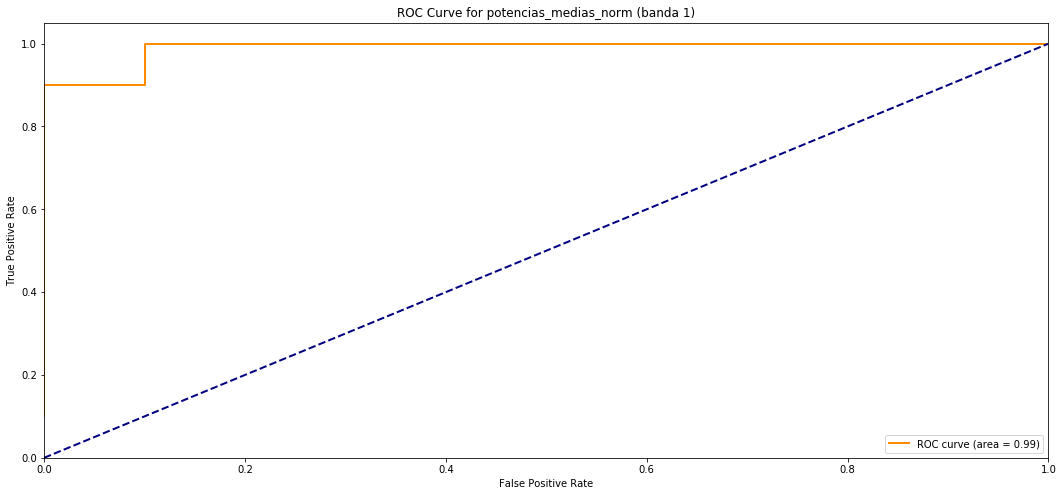

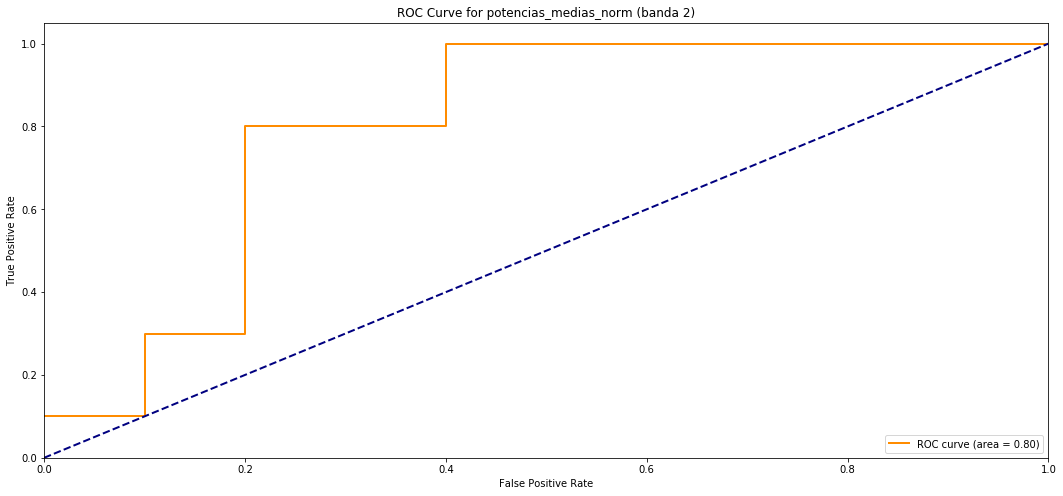

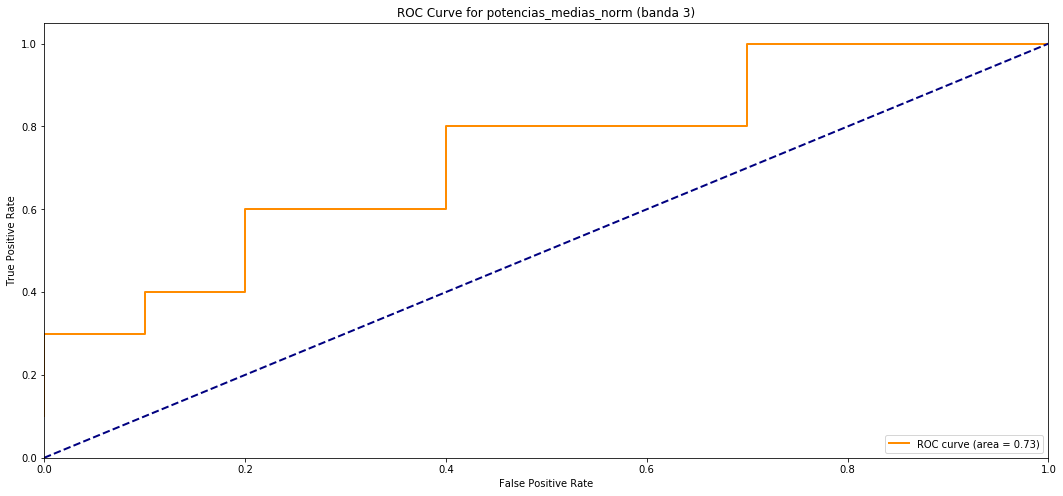

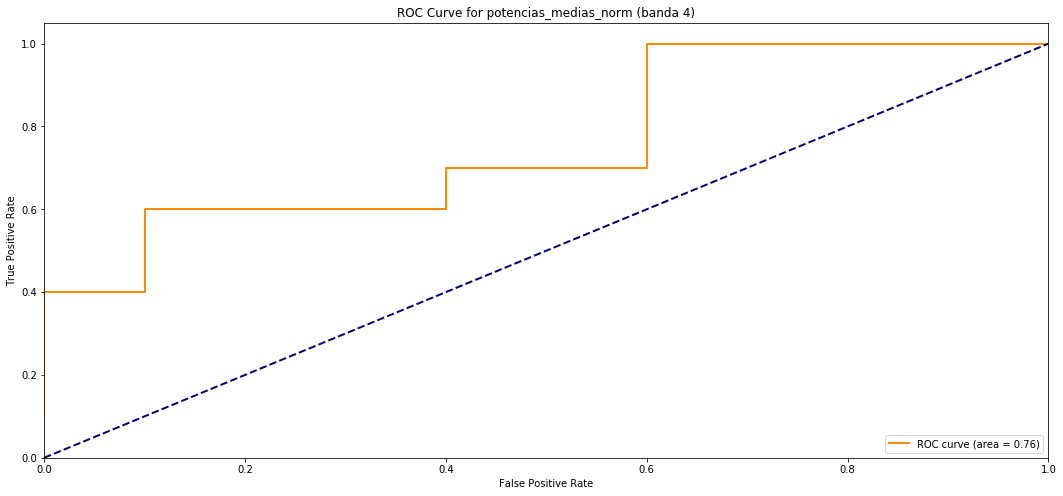

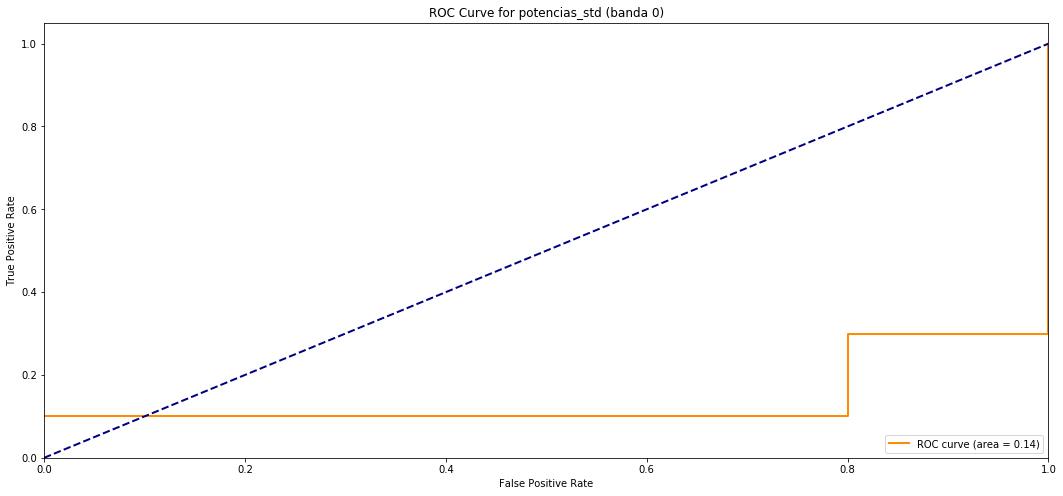

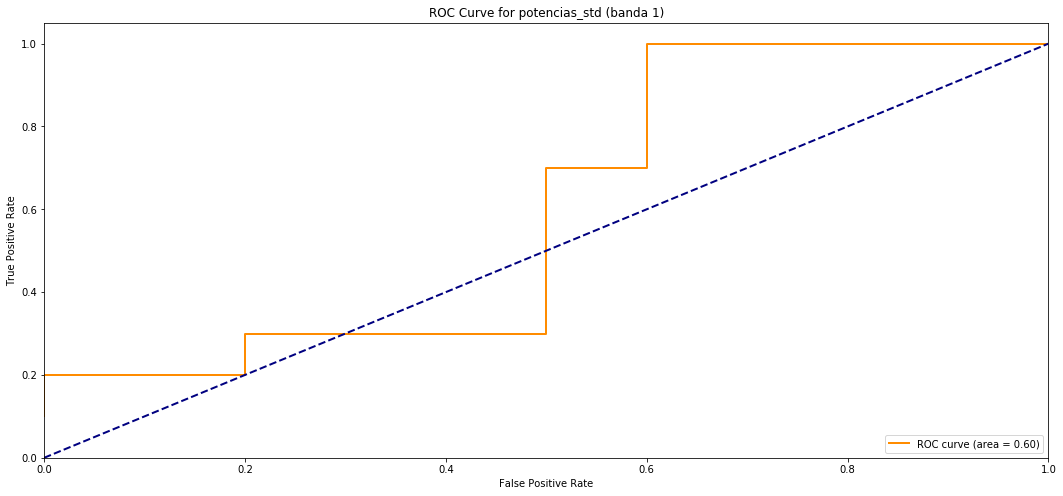

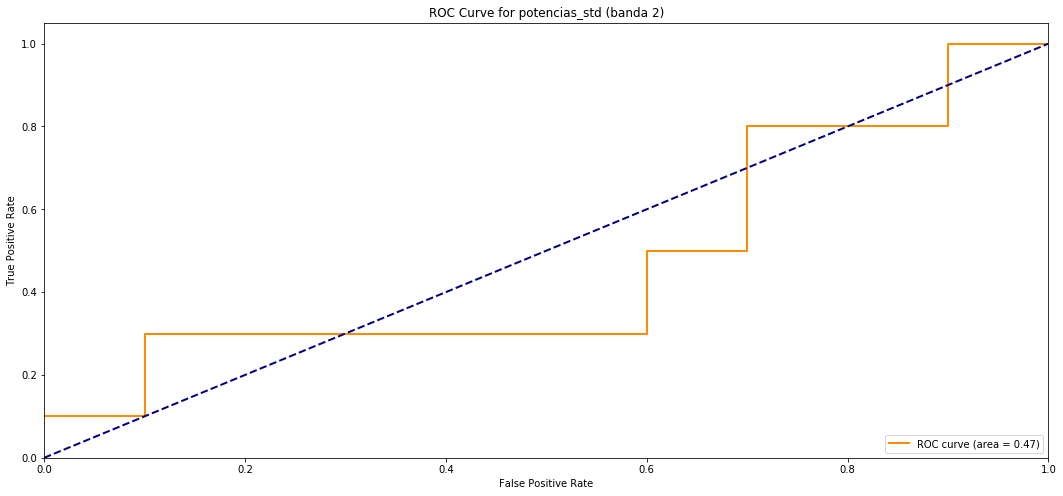

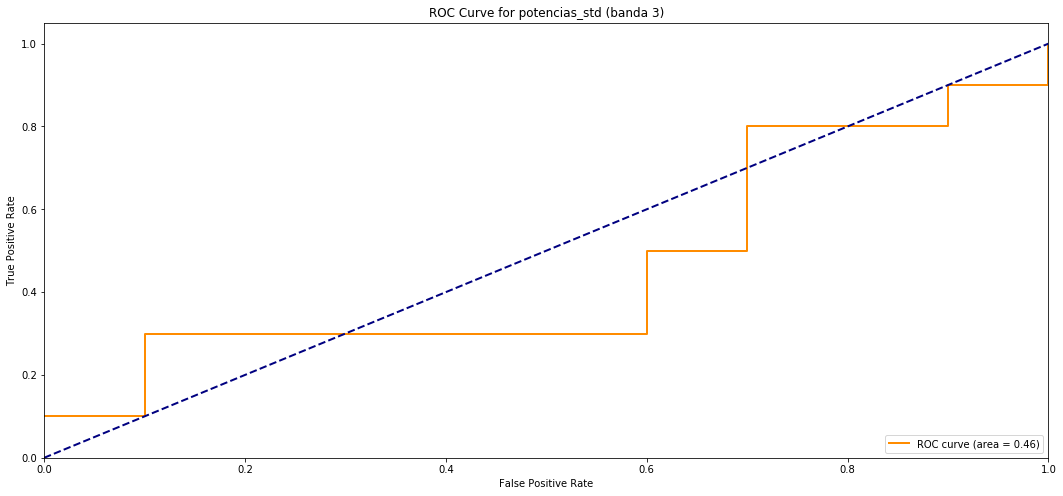

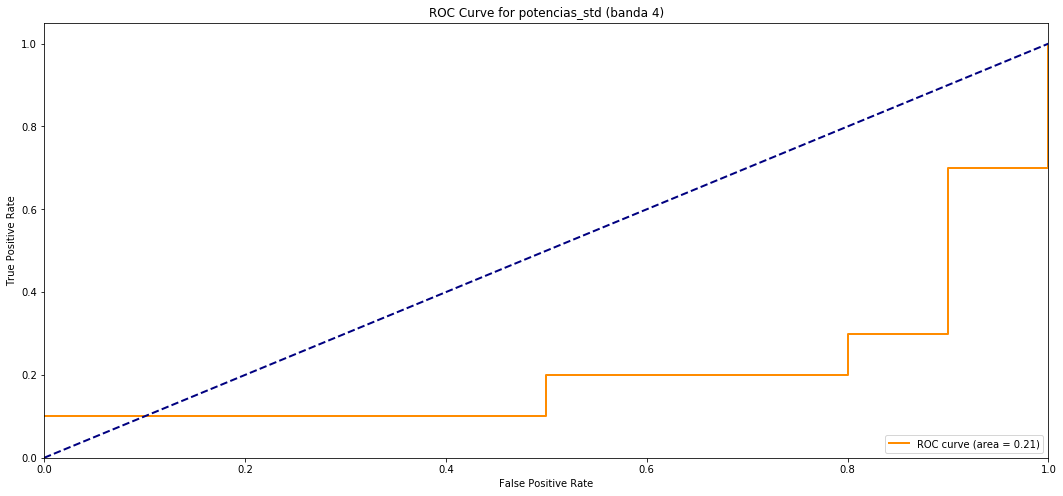

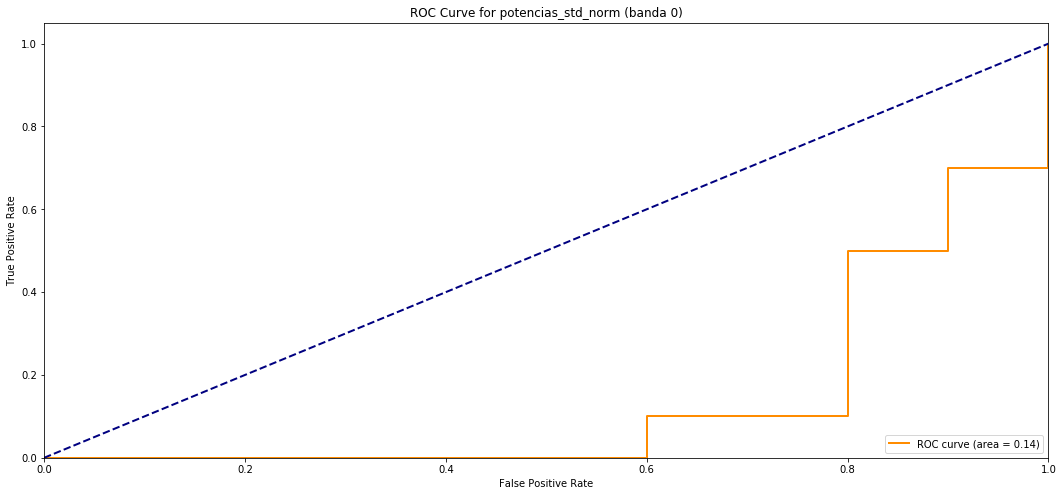

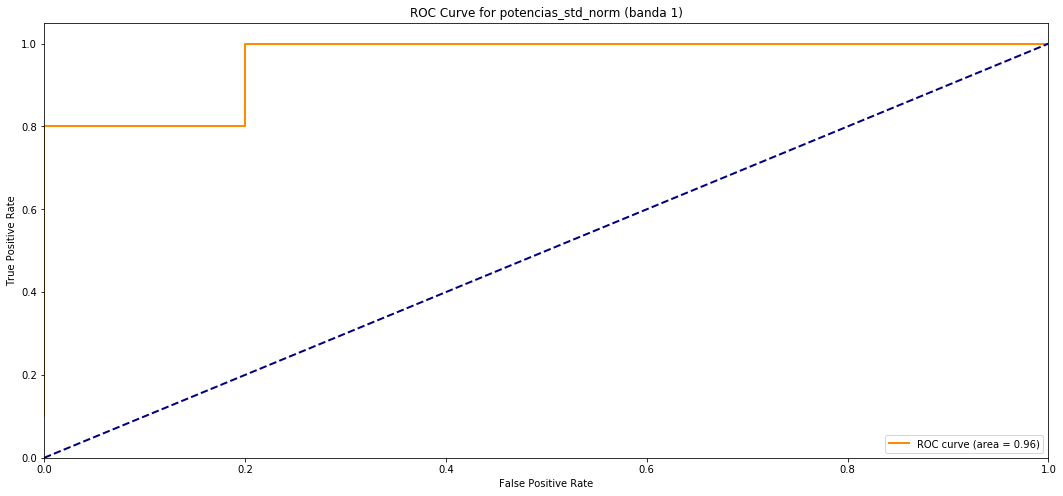

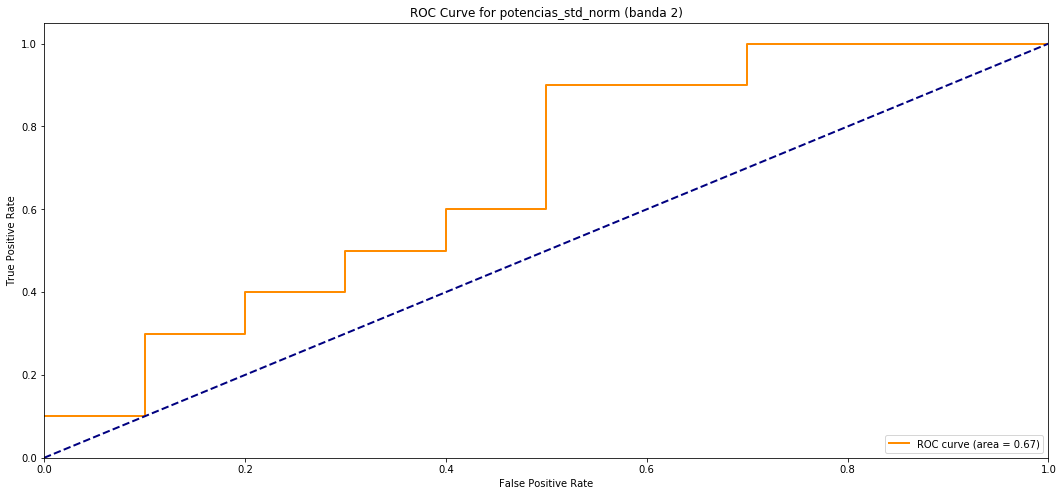

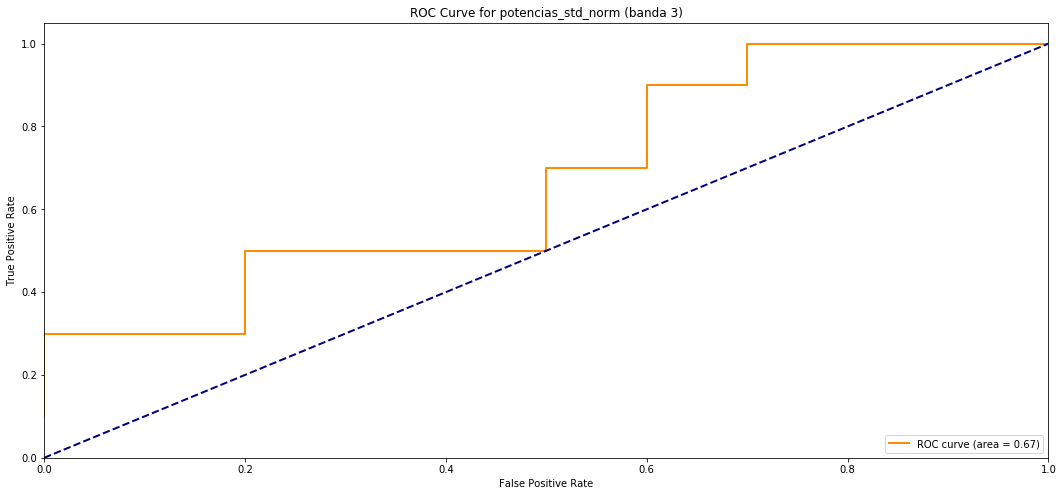

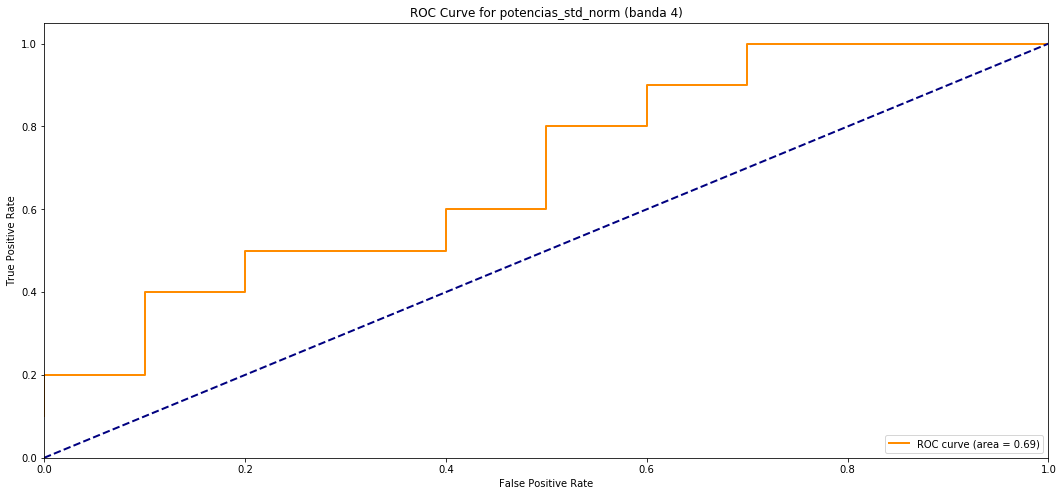

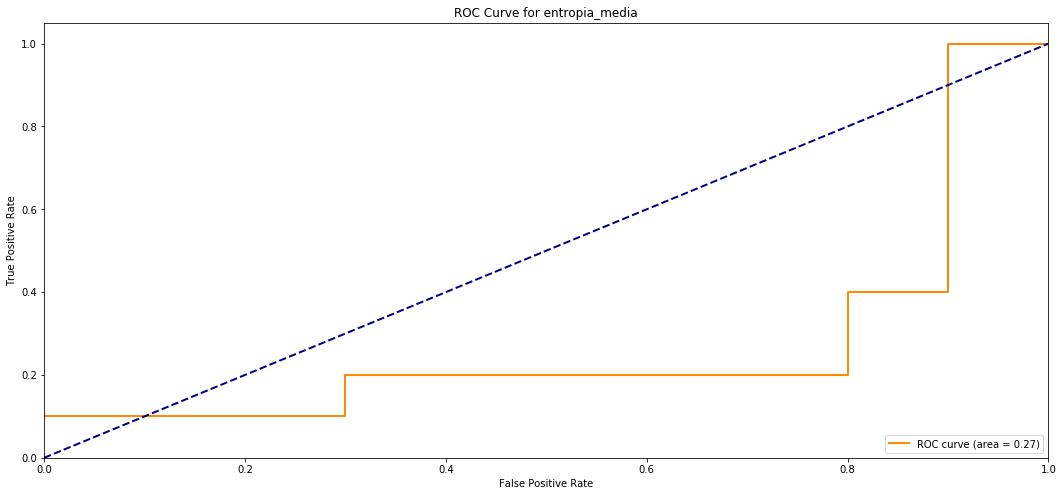

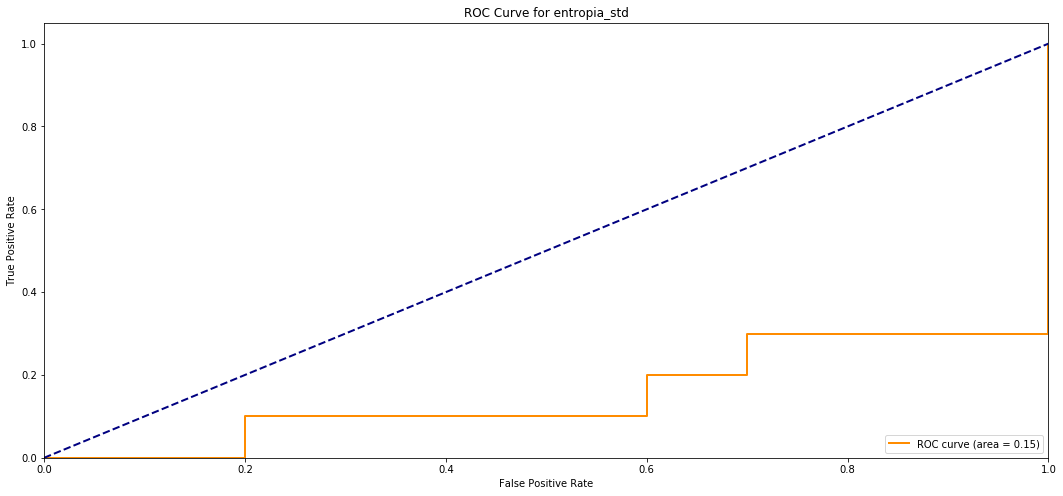

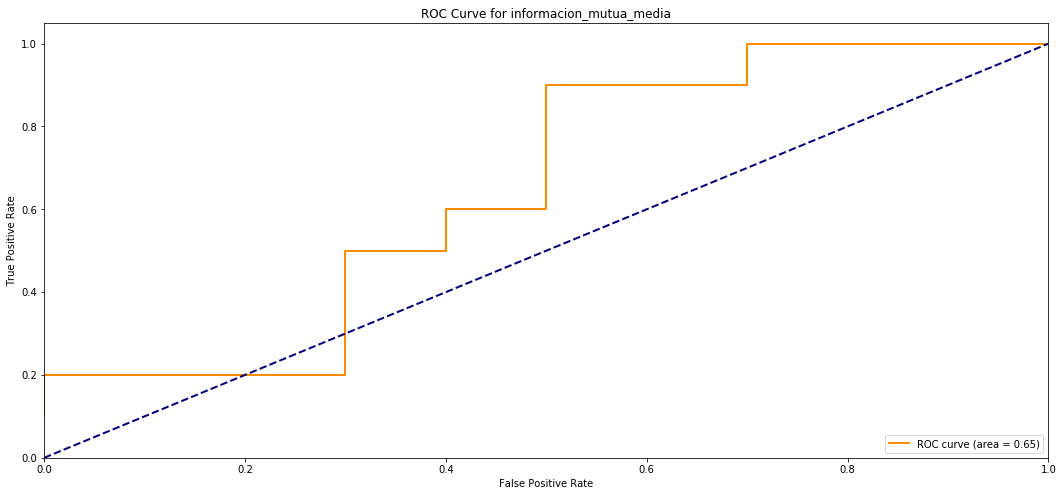

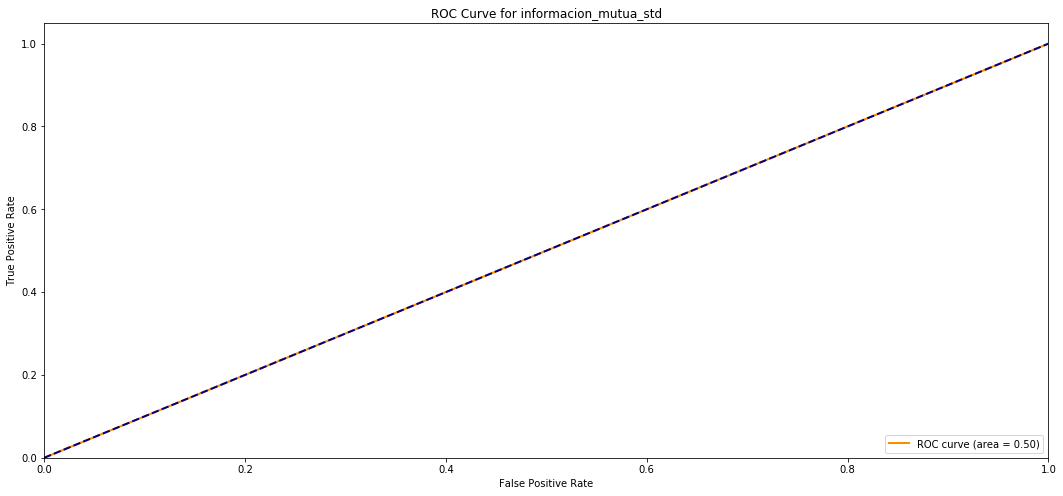

In [ ]:
draw_roc_curve_for_electrodes([0])

Para la curva ROC, la banda Theta normalizada da un area de 0.99. Pareceria ser un muy buen indicador para el clasificador, por lo cual probamos para los electrodos del entorno con el objetivo de descartar errores de medicion.

In [ ]:
electrodos = [229, 225, 224, 220, 219, 221]
get_data_for_electrodes(electrodos)
draw_roc_curve_for_electrodes(electrodos)

dataset/P01.mat


Probamos con la misma zona en el hemisferio opuesto

In [ ]:
electrodos = [252, 251, 247, 60, 54, 47]
get_data_for_electrodes(electrodos)
draw_roc_curve_for_electrodes(electrodos)

Probamos con una zona de la corteza frontal

In [ ]:
electrodos = [135, 136, 146, 147, 145, 155]
get_data_for_electrodes(electrodos)
draw_roc_curve_for_electrodes(electrodos)

Vemos que, si bien hay diferencias y el area bajo la curva ROC del feature "potencia media" de la banda Theta normalizada es menor, sigue siendo un buen clasificador.

## b) Utilizando una técnica de cross validación, estimar la performance de un classificador Logistic Regression para cada feature y graficar la curva ROC correspondiente. ¿Cuál es su conclución respecto a los resultados obtenidos en el punto anterior?

Decidimos utilizar todo el dataset como entrenamiento y, subsecuentemente, testear sobre el mismo al final. Gracias a la elección de la clase LogisticRegressionCV y su utilización de KStratifiedFold, nunca utilizamos todo el dataset al mismo tiempo (sino que internamente lo divide en folds).

Nos quedamos con aquellos electrodos que originalmente mostraron ser los mejores indicadores, esto es, aquellos alrededor del electrodo 1

In [ ]:
electrodos = [229, 225, 224, 220, 219, 221]

def get_classifier_matrix(electrodos):
    features_per_subject = get_data_for_electrodes(electrodos)
    target_vector = get_target_vector(features_per_subject)
    classifier_matrix = []

    for subject, feature_dict in features_per_subject.items():
        valores, feature_names = [], []
        for feature_name, values in feature_dict.items():
            feature_names.append(feature_name)
            if isinstance(values, float):
                valores.append(values)
            else:
                valores.extend(values)
                
        classifier_matrix.append(valores)
                
    print("Orden de los features:", feature_names)
    return np.array(classifier_matrix), target_vector

classifier_matrix, target_vector = get_classifier_matrix(electrodos)

cant_sujetos, cant_features = classifier_matrix.shape

for i in range(cant_features):
    datos_por_sujeto = classifier_matrix[:, i].reshape(-1, 1)
    clasificador_lr = LogisticRegressionCV()
    clasificador_lr.fit(datos_por_sujeto, target_vector)
     # Nos quedamos con la primera columna de predict_proba ya que al ser dos clases son simétricas
    y_score = clasificador_lr.predict_proba(datos_por_sujeto)[:, 0]
    draw_roc_curve(target_vector, y_score, title=str(i))

Podemos observar que ciertas features que daban una curva ROC muy mala en el punto A) resultan malos clasificadores, como por ejemplo las potencias no normalizadas por banda. En cambio, features con una curva ROC muy lejana al 0.5 en el punto A) resultaron buenos clasificadores, con el mejor clasificador correspondiéndose a la mejor curva ROC obtenida previamente, la potencia normalizada de la banda Theta. 

Como conclusión final, existe una clara correlación entre los resultados obtenidos en el punto anterior con lo obtenido en este punto. Las potencias normalizadas son mejores clasificadores que las no normalizadas. Para las potencias, las medias resultan un mejor indicador para buenos clasificadores, comparado con la desviación estándar.
En cambio, el mejor clasificador para la entropía está asociado a su desviación estándar, por lo que no parecería haber una inclinación permanente por la media o la desviación a nivel general en primera instancia.

# 2.2 Análisis Multivariado

## a) Utilizar todos los features y entrenar un clasificador basado en Support Vector Machine. Computar la curva roc y graficarla. No olvidar reportar el area bajo la curva.

Entrenamos sobre 18 sujetos y testeamos sobre 2 (los que no usamos) para obtener el score.

In [ ]:
classifier_matrix, target_vector = get_classifier_matrix(electrodos)

X_train, X_test, y_train, y_test = train_test_split(
    classifier_matrix, target_vector, test_size=0.2, random_state=42)

clasificador_svc = SVC(probability=True, random_state=42)
clasificador_svc.fit(X_train, y_train)
# Nos quedamos con la primera columna de predict_proba ya que al ser dos clases son simétricas
y_score = clasificador_svc.predict_proba(X_train)[:, 0]
draw_roc_curve(y_train, y_score, title="Curva ROC para Clasificador SVM")
print('Score para sujetos de test:', clasificador_svc.score(X_test, y_test))

# b) Repetir el punto a), pero utilizando un pipeline de Scikit-Learn con los siguientes 3 pasos: Standard Scaler, Feature Selection utilizando solo el 10%, SVC.

In [ ]:
def do_pipeline(percentile):
    classifier_matrix, target_vector = get_classifier_matrix(electrodos)

    X_train, X_test, y_train, y_test = train_test_split(
        classifier_matrix, target_vector, test_size=0.2, random_state=42)

    pipeline = make_pipeline(
        StandardScaler(), 
        SelectPercentile(percentile=percentile),
        SVC(probability=True, random_state=42)
    )
    pipeline.fit(X_train, y_train)
    # Nos quedamos con la primera columna de predict_proba ya que al ser dos clases son simétricas
    y_score = pipeline.predict_proba(X_train)[:, 0]
    draw_roc_curve(y_train, y_score, title="Curva ROC para Clasificador SVM c/ pipeline")
    print('Score para sujetos de test:', pipeline.score(X_test, y_test))

In [ ]:
do_pipeline(10)

In [ ]:
do_pipeline(20)

In [ ]:
do_pipeline(35)